In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import ahrs
import consts
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from quat import prop_matrix
from usque import run_ukf, DEFAULT_TYPE
from consts import n, N

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
"""
Generate synthetic data for UKF
"""

from typing import Tuple
from quat import prop_matrix
from sensors import acc_read
import numpy as np
from consts import N, dt, sig_gy_w, sig_gy_b, sig_acc
import scipy
from scipy.integrate import cumulative_trapezoid

def gen_data(gt_omega=None) -> Tuple:
    """
    Returns noisy gyro and accel, as well as GT attitude
    """
    if gt_omega is None:
        # Generate gt angular velocity
        gt_omega = np.zeros((N, 3, 1))
        num_acc_steps = 5
        for i in range(3):
            acc_fn = scipy.interpolate.interp1d(
                np.arange(num_acc_steps + 1),
                np.random.randn(num_acc_steps + 1) * dt / 50,
                kind="cubic",
            )
            gt_omega[:, i, 0] = cumulative_trapezoid(
                acc_fn(np.linspace(0, num_acc_steps, N)), dx=dt, initial=0, axis=0
            )
    
    # Make omega zero for the last chunk of time
    stationary_time = int(N * 0.33)
    gt_omega[-stationary_time: ] = 0
    # gt_omega[:stationary_time] = 0
    
    # Generate gt attitude
    gt_q = np.zeros((N, 4, 1))
    gt_q[0,3] = 1
    for i in range(1, N):
        gt_q[i] = prop_matrix(gt_omega[i]) @ gt_q[i - 1]
        # normalize
        gt_q[i] /= np.linalg.norm(gt_q[i])

    gt_bias_drift = np.random.randn(N, 3, 1) * sig_gy_b
    gt_bias = cumulative_trapezoid(gt_bias_drift, dx=dt, initial=0, axis=0)
    # gt_bias += np.random.randn(3, 1) * sig_gy_b * 10 # Jump start the bias
    # gt_bias = np.zeros((N, 3, 1))

    noisy_omega = gt_omega + gt_bias + np.random.randn(N, 3, 1) * sig_gy_w
    noisy_acc = np.zeros((N, 3, 1))
    for i in range(N):
        noisy_acc[i] = acc_read(gt_q[i]) + np.random.randn(3, 1) * sig_acc
    t = np.arange(gt_q.shape[0]) * dt

    return t, gt_q, gt_omega, gt_bias, noisy_omega, noisy_acc

def load_data(path):
    data = np.load(path)
    gt_q = data["gt_q"]
    gt_omega = data["gt_omega"]
    gt_bias = data["gt_bias"]
    noisy_omega = data["noisy_omega"]
    noisy_acc = data["noisy_acc"]
    t = np.arange(gt_q.shape[0]) * data["dt"]
    return t, gt_q, gt_omega, gt_bias, noisy_omega, noisy_acc



## Load or generate data

In [12]:
grade = consts.imu_grade
load = False

print(f"Using {grade} grade IMU, to change: go to consts.py line 4")
fname = f"data/{grade.lower()}.npz"
t, gt_q, gt_omega, gt_bias, noisy_omega, noisy_acc = load_data(fname) if load else gen_data()
if load:
    print(f"Loaded from file: {fname}")

Using tac grade IMU, to change: go to consts.py line 4


## Visualize data

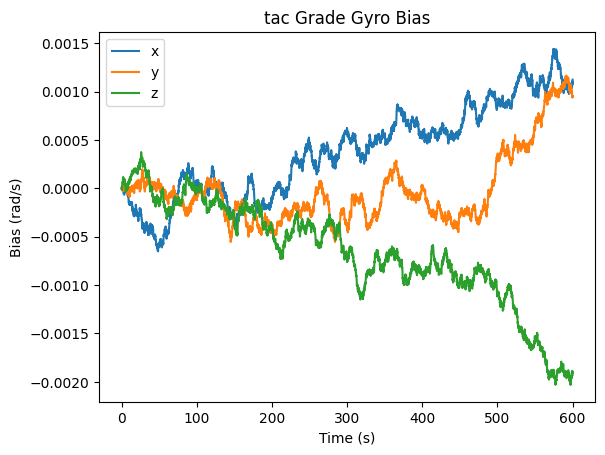

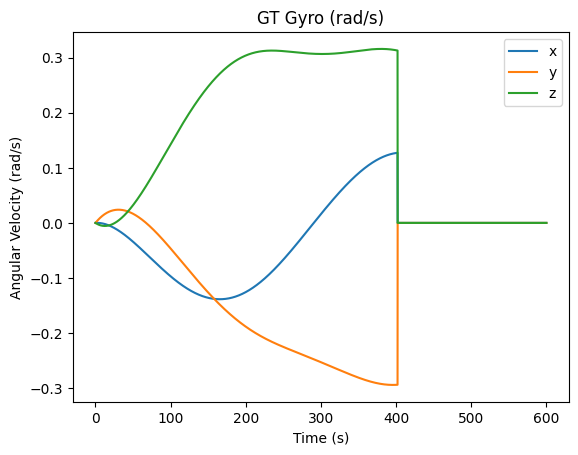

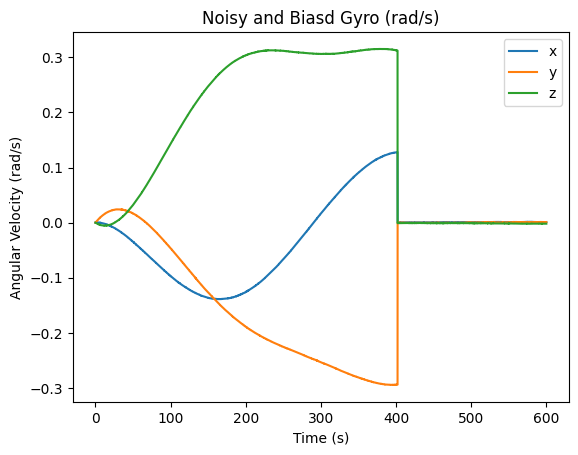

In [13]:
plt.figure()
plt.plot(t, gt_bias[:, :, 0])
plt.xlabel('Time (s)')
plt.ylabel("Bias (rad/s)")
plt.legend(['x', 'y', 'z'])
plt.title(f'{grade} Grade Gyro Bias')
plt.show()
plt.figure()
plt.plot(t, gt_omega[:, :, 0])
plt.xlabel('Time (s)')
plt.ylabel("Angular Velocity (rad/s)")
plt.legend(['x', 'y', 'z'])
plt.title('GT Gyro (rad/s)')
plt.show()

plt.figure()
plt.plot(t, noisy_omega[:, :, 0])
plt.xlabel('Time (s)')
plt.ylabel("Angular Velocity (rad/s)")
plt.legend(['x', 'y', 'z'])
plt.title('Noisy and Biasd Gyro (rad/s)')
plt.show()

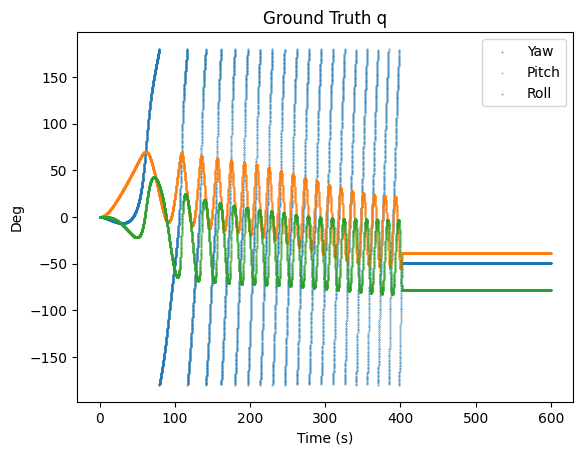

In [36]:
def plot_q(q: np.ndarray, title: str = None) -> None:
    assert q.shape[1] == 4
    if len(q.shape) == 3:
        q = q[:, :, 0]
    rot = R.from_quat(q)
    ypr = rot.as_euler("ZYX", degrees=True)
    plt.scatter(t, ypr[:, 0], s=0.1, label="Yaw")
    plt.scatter(t, ypr[:, 1], s=0.1, label="Pitch")
    plt.scatter(t, ypr[:, 2], s=0.1, label="Roll")
    if title is not None:
        plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Deg")
    plt.legend()

def get_err(q_est, q_gt):
    if len(q_est.shape) == 3:
        q_est = q_est[:, :, 0]
    if len(q_gt.shape) == 3:
        q_gt = q_gt[:, :, 0]
    
    assert q_est.shape == q_gt.shape
    N, _ = q_est.shape

    rpy_est = R.from_quat(q_est).as_euler("ZYX", degrees=True)
    rpy_gt = R.from_quat(q_gt).as_euler("ZYX", degrees=True)
    
    rot_errs = rpy_est - rpy_gt
    rot_errs = (rot_errs + 360) % 360  # Make all positive
    rot_errs[rot_errs > 180] -= 360 # 2 pi wrap errors
    
    plt.scatter(t, rot_errs[:, 1], s=0.1)
    plt.scatter(t, rot_errs[:, 2], s=0.1)
    # plt.ylim([-3, 3])
    plt.legend(["Pitch", "Roll"])

    return rot_errs.copy()

plot_q(gt_q, title="Ground Truth q")
plt.show()

## Run trial for each method

100%|██████████| 11999/11999 [00:29<00:00, 410.73it/s]


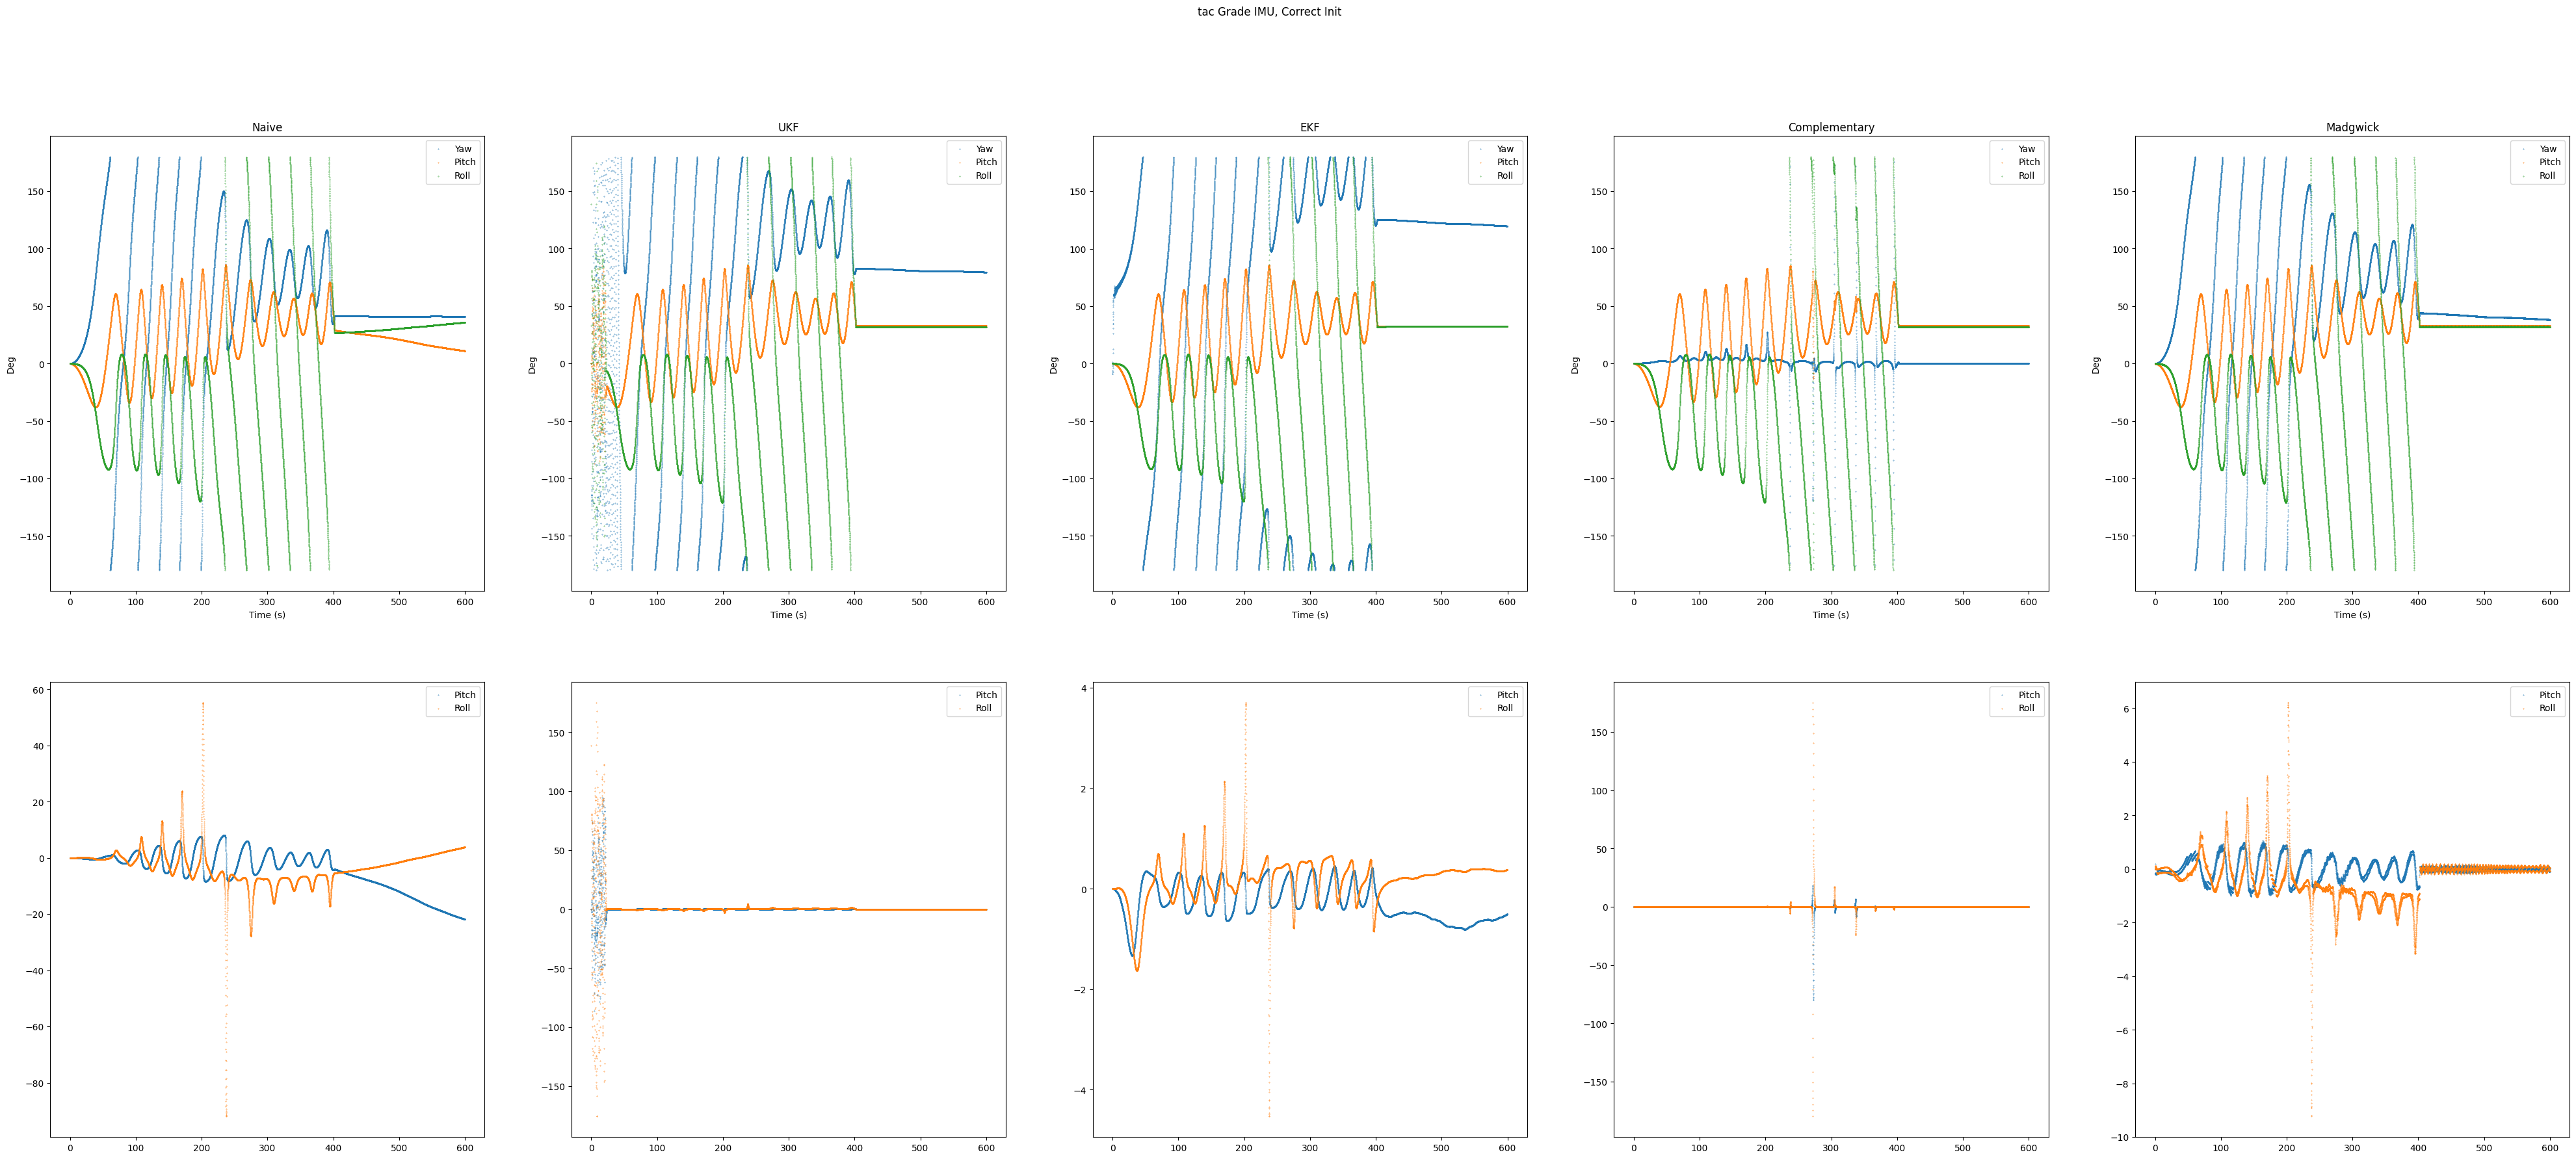

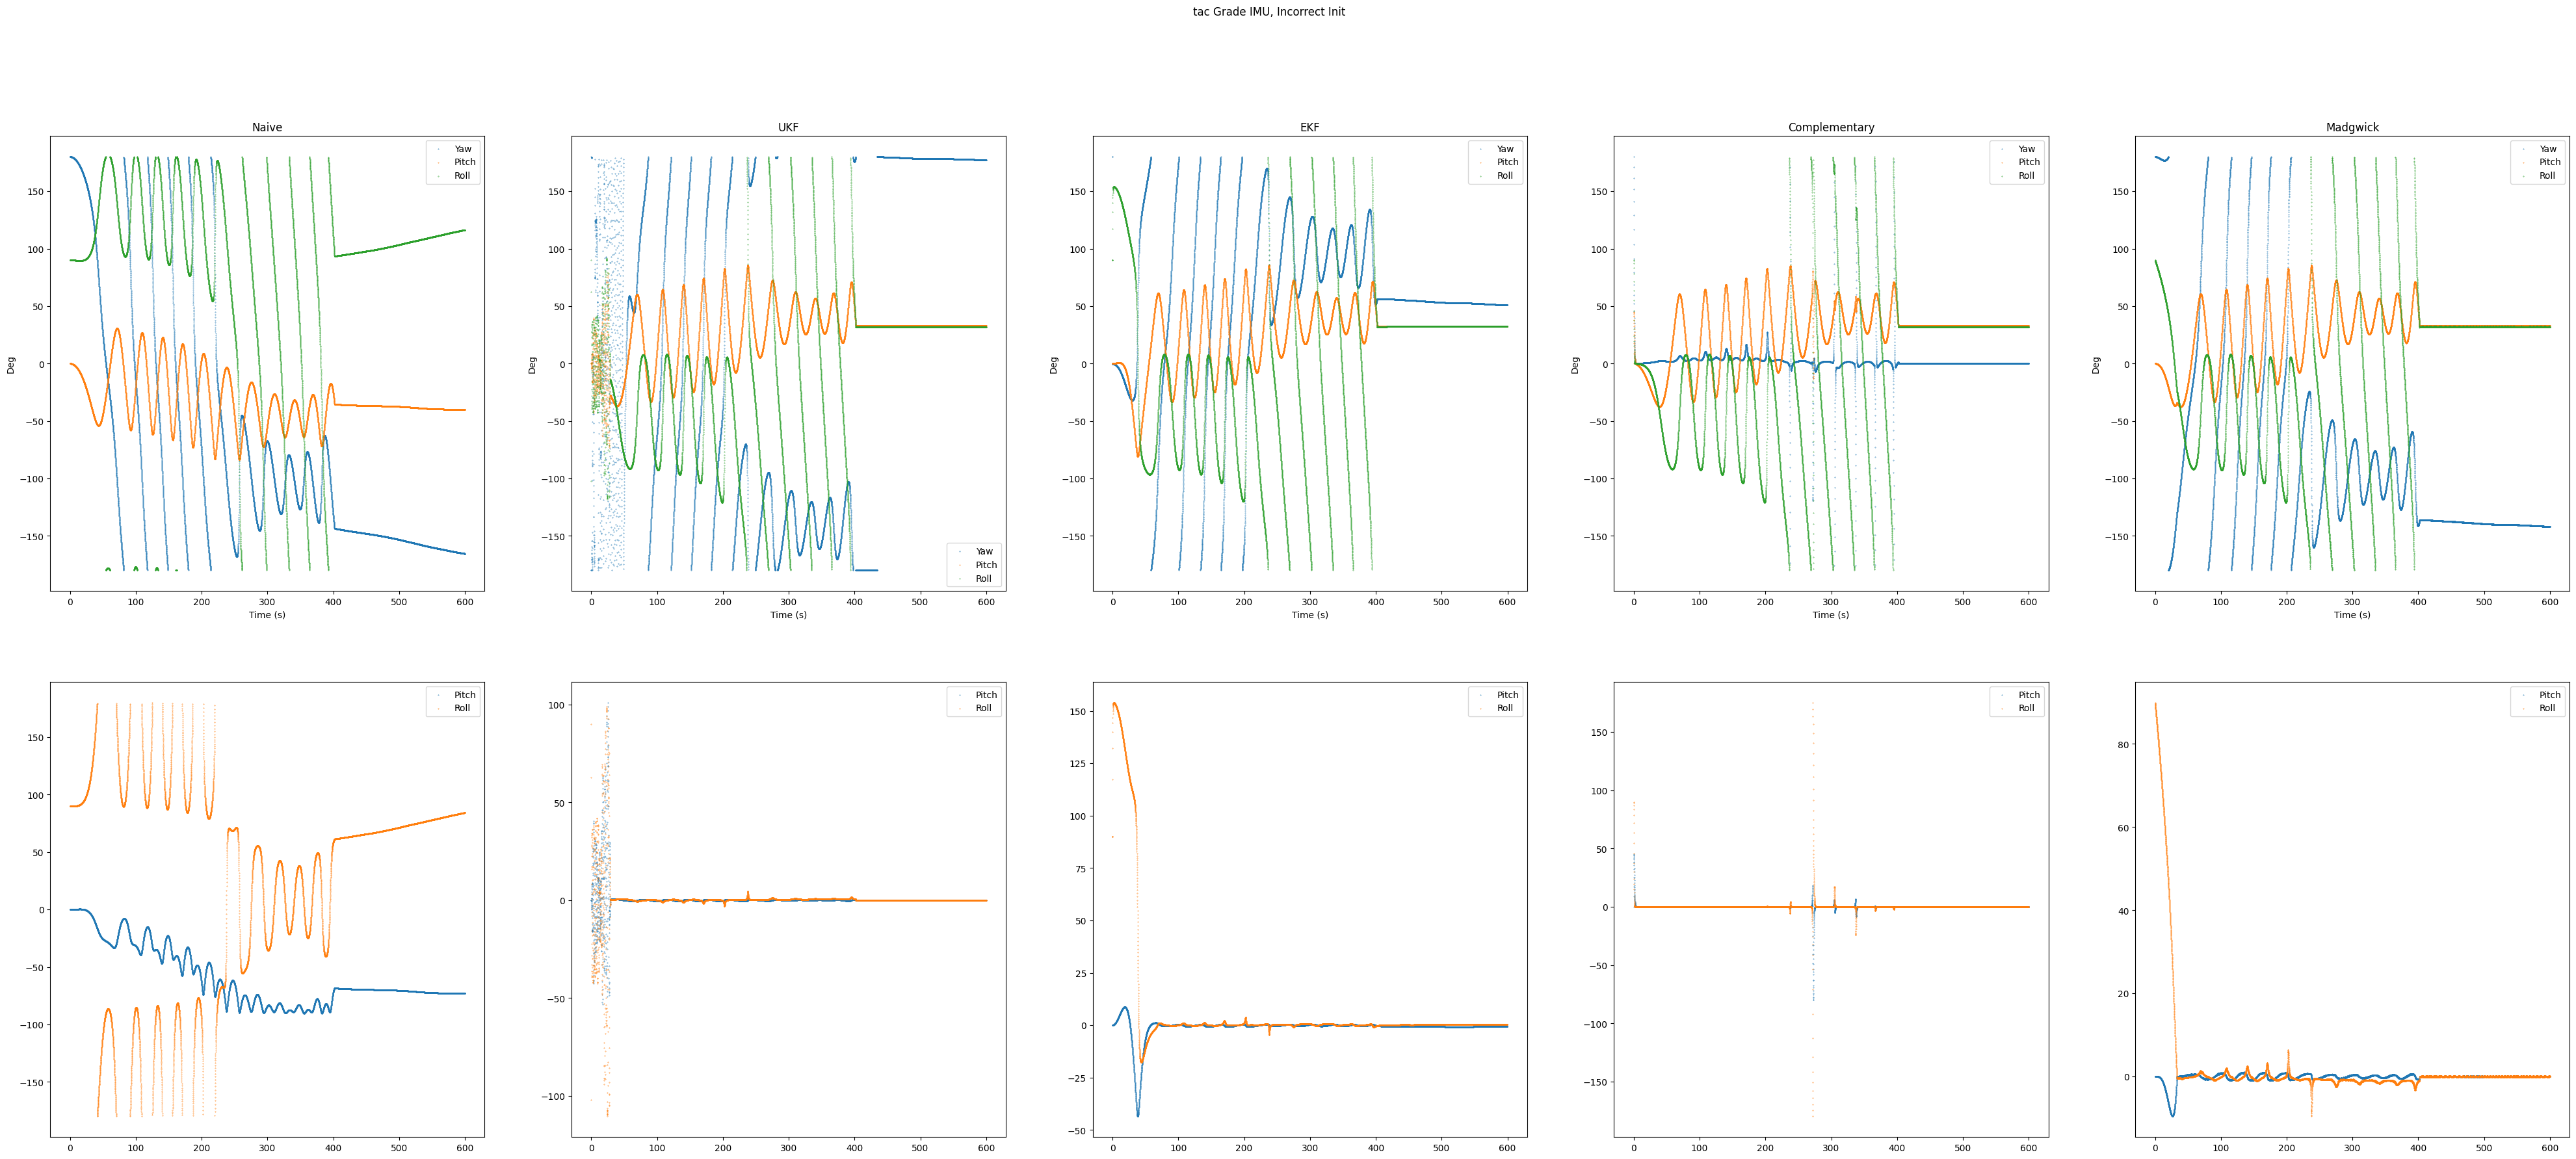

In [37]:

def run_trial(grade):
    grade_str = grade.lower()
    t, gt_q, gt_omega, gt_bias, noisy_omega, noisy_acc = load_data(f"data/{grade_str}.npz")
    Y = noisy_acc  # IMU Accel observations
    W = noisy_omega  # IMU Gyro observations

    for i, q0 in enumerate((np.array([[0, 0, 0, 1]]).T, 0.5 * np.array([[0, np.sqrt(2), np.sqrt(2), 0]]).T)):
        fig = plt.figure(figsize=(50, 20))
        q0_wxyz = q0[(3, 0, 1, 2), :]
        if i == 0:
            q0_str = "Correct Init"
        else:
            q0_str = "Incorrect Init"
        fig.suptitle(f"{grade} Grade IMU, {q0_str}")

        # Naive
        naive_q = np.zeros((N, 4, 1))
        naive_q[0, :, 0] = q0[:, 0]
        for i in range(1, N):
            naive_q[i] = prop_matrix(W[i]) @ naive_q[i - 1]
            # normalize
            naive_q[i] /= np.linalg.norm(naive_q[i])
        fig.add_subplot(2, 5, 1)
        plot_q(naive_q, title="Naive")
        fig.add_subplot(2, 5, 6)
        naive_errs = get_err(naive_q, gt_q)
        # UKF
        x0 = np.array([[0, 0, 0, 0, 0, 0]], dtype=DEFAULT_TYPE).T
        
        P0 = np.eye(6)
        if i == 0:
            P0[:3, :3] *= 1e-3
        else: 
            P0[:3, :3] *= 1e1
        P0[3:, 3:] *= 1e-3
        ukf_q, P = run_ukf(x0, P0, W, Y, q0)
        fig.add_subplot(2, 5, 2)
        plot_q(ukf_q, title="UKF")
        fig.add_subplot(2, 5, 7)
        ukf_errs = get_err(ukf_q, gt_q)
        
        # EKF
        ekf = ahrs.filters.ekf.EKF(gyr=W[:, :, 0], acc=-Y[:, :, 0], frequency=consts.fs, q0=q0_wxyz[:, 0], var_acc=consts.sig_acc**2, var_gyr=consts.sig_gy_w**2)
        ekf_q = ekf.Q # wxyz
        ekf_q = ekf_q[:, (1, 2, 3, 0)]
        fig.add_subplot(2, 5, 3)
        plot_q(ekf_q, title="EKF")
        fig.add_subplot(2, 5, 8)
        ekf_errs = get_err(ekf_q, gt_q)

        # Comp
        comp_filt = ahrs.filters.complementary.Complementary(gyr=W[:, :, 0], acc=Y[:, :, 0], frequency=consts.fs, gain=0.1, q0=q0_wxyz[:, 0])
        q_cf = comp_filt.Q
        comp_q = q_cf[:, (1, 2, 3, 0)]
        fig.add_subplot(2, 5, 4)
        plot_q(comp_q, title="Complementary")
        fig.add_subplot(2, 5, 9)
        comp_errs = get_err(comp_q, gt_q)

        # Madg
        madg = ahrs.filters.madgwick.Madgwick(gyr=W[:, :, 0], acc=Y[:, :, 0], frequency=consts.fs, q0=q0_wxyz[:, 0])
        madg_q = madg.Q
        madg_q = madg_q[:, (1, 2, 3, 0)]
        fig.add_subplot(2, 5, 5)
        plot_q(madg_q, title="Madgwick")
        fig.add_subplot(2, 5, 10)
        madg_errs = get_err(madg_q, gt_q)

    plt.show()

grade = consts.imu_grade # !Note: change the value in consts.py to change the grade!
run_trial(grade)